In [1]:
import matplotlib.pyplot as plt
from enum import Enum
import random
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import os

State = Enum('State', ['STAY', 'MOVING', 'MOVING_TO_STATION', 'STAY_AT_STATION'])
Transition = Enum('Transition', ['HOME|STAY', 'STATION|STAY', 'POI|ANY', 'HOME|STAY_AT_STATION'])
Destination = Enum('Destination', ['POI', 'STAY', 'HOME', 'STATION'])

def transition(person):
    
    if person.state == State.STAY_AT_STATION:
        if random.random() < person.transitions[Transition['HOME|STAY_AT_STATION'].value-1]:
            return Destination.HOME
        else:
            return Destination.STAY
    else:
        if random.random() < person.transitions[Transition['STATION|STAY'].value-1]:
            return Destination.STATION
        elif random.random() < person.transitions[Transition['HOME|STAY'].value-1]:
            return Destination.HOME
        elif random.random() < person.transitions[Transition['POI|ANY'].value-1]:
            return Destination.POI
        else:
            return Destination.STAY

class Person:
    def __init__(self, x, y, id, speed, transitions, home):
        self.id = id
        self.x = x
        self.y = y
        self.home = home
        self.speed = speed
        self.destination = None
        self.state = State.STAY
        self.transitions = transitions

    def move(self):
        if (self.state == State.MOVING or self.state == State.MOVING_TO_STATION) and self.destination is not None:
            dx = self.destination.x - self.x
            dy = self.destination.y - self.y
            distance = (dx ** 2 + dy ** 2) ** 0.5
            if distance > self.speed:
                self.x += self.speed * dx / distance
                self.y += self.speed * dy / distance
            else:
                self.x, self.y = self.destination.x, self.destination.y
                self.wait()
                
    def set_destination(self, destination, station=False):
        self.destination = destination
        if station:
            self.state = State.MOVING_TO_STATION
        else:
            self.state = State.MOVING
    
    def set_transitions(self, transitions):
        self.transitions = transitions

    def wait(self):
        self.destination = None
        
        if self.state == State.MOVING_TO_STATION:
            self.state = State.STAY_AT_STATION
        else:
            self.state = State.STAY

class PointOfInterest:
    def __init__(self, x, y, name):
        self.x = x
        self.y = y
        self.name = name

class Map:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.poi = []
        self.stations = []
        self.people = {}

    def add_poi(self, poi):
        self.poi.append(poi)
        
    def clean_poi(self):
        self.poi = []
    
    def add_station(self, station):
        self.stations.append(station)

    def add_person(self, person):
        self.people[person.id] = person

    def remove_person(self, person):
        self.people.pop(person.id, None)

    def update(self):
        for _, person in self.people.items():
            if person.state == State.STAY or person.state == State.STAY_AT_STATION:
                destination = transition(person)
                self.change_people_dest(person, destination)
            person.move()

    def visualize(self):
        plt.figure()
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        #for poi in self.poi:
         #   plt.plot(poi.x, poi.y, 'x', label=poi.name)
        for id, person in self.people.items():
            plt.plot(person.x, person.y, 'or')
        plt.grid(True)
        plt.show()
    
    def visualize_pois(self):
        plt.figure()
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        for poi in self.poi:
            plt.plot(poi.x, poi.y, 'x', label=poi.name)
        plt.grid(True)
        plt.show()

    def calculate_nearest_poi(self, person, threshold=30):
        nearest_poi = None
        min_distance = float('inf')
        for poi in self.poi:
            if poi != person.destination:
                dx = poi.x - person.x
                dy = poi.y - person.y
                distance = (dx ** 2 + dy ** 2) ** 0.5
                if distance < min_distance and distance > threshold:
                    min_distance = distance
                    nearest_poi = poi
        return nearest_poi
    
    def calculate_nearest_station(self, person, threshold=30):
        nearest_station = None
        min_distance = float('inf')
        
        for station in self.stations:
            if station != person.destination:
                dx = station.x - person.x
                dy = station.y - person.y
                distance = (dx ** 2 + dy ** 2) ** 0.5
                if distance < min_distance and distance > threshold:
                    min_distance = distance
                    nearest_station = station
        return nearest_station  
        #return random.choice(self.stations)
    
    def change_people_dest(self, person, destination):
        if destination == Destination.STAY:
            person.wait()
        elif destination == Destination.POI:
            poi = self.calculate_nearest_poi(person)
            person.set_destination(poi)
        elif destination == Destination.STATION:
            station = self.calculate_nearest_station(person)
            person.set_destination(station, station=True)
        elif destination == Destination.HOME:
            person.set_destination(person.home)
    
    def calculate_density(self, region_size, to_array=False):
        density = {}
        for id, p in self.people.items():
            x, y = p.x, p.y
            region_x = x // region_size  
            region_y = y // region_size  
            region = (region_x, region_y) 
    
            density[region] = density.get(region, 0) + 1
        if to_array:
            density = [[density.get((i, j), 0) for j in range(self.width // region_size)] for i in range(self.height // region_size)]
        return density
    
    def visualize_density(self, region_size, density):
        density_plot = [[density.get((i, j), 0) for j in range(self.width // region_size)] for i in range(self.height // region_size)]

        sns.set(style="whitegrid")
        sns.heatmap(density_plot, cmap="YlOrRd", square=False, xticklabels=False, yticklabels=False)
        plt.show()

def random_start(p, mmap):
    choices = ['STAY', 'POI', 'STATION', 'HOME']
    c = random.choice(choices)
    
    if c == 'STAY':
        p.wait()
    elif c == 'POI':
        poi = mmap.calculate_nearest_poi(p)
        p.set_destination(poi)
    elif c == 'STATION':
        station = mmap.calculate_nearest_station(p)
        p.set_destination(station, station=True)
    else:
        p.set_destination(p.home)
        
def generate_persons(num_persons, mmap, homes, speed):
    persons = []
    for i in range(num_persons):
        
        x = int(random.uniform(0, mmap.width))
        y = int(random.uniform(0, mmap.height))
        
        x_home = int(random.uniform(0, mmap.width-speed))
        y_home = int(random.uniform(0, mmap.height-speed))  
        home = PointOfInterest(x, y, f'home {i}')
        
        transitions = []
        for _ in range(4):
            transitions.append(round(np.random.normal(0.4, 0.2),3))
        
        home = random.choice(homes)
        p = Person(x, y, f'{i}', speed, transitions, home)
        homes.remove(home)
        
        #random_start(p, mmap)
        persons.append(p)
    return persons

def generate_pois(num_poi, map_width, map_height, speed):
    pois = []

    for i in range(num_poi):
        
        x = int(random.uniform(0, map_width-speed))
        y = int(random.uniform(0, map_height-speed))
        pois.append(PointOfInterest(x, y, f'{i}'))
        
    return pois

In [2]:
def generate_pois2(num_central, num_around, map_width, map_height, speed, mean=10, stddev=5):
    map_width -= speed
    map_height -= speed
    
    points = []
    pois = []

    for i in range(num_central):
        x = random.randint(0, int(map_width))
        y = random.randint(0, int(map_height))
        point = (x, y)
        points.append(point)
        pois.append(PointOfInterest(x, y, f'{i}'))

    all_points = []
    all_pois = []
    for j, point in enumerate(points):  
        for i in range(num_around):
            delta_x = np.random.normal(mean, stddev)
            delta_y = np.random.normal(mean, stddev)
            
            new_x = min(max(0, point[0] + int(delta_x)), map_width)
            new_y = min(max(0, point[1] + int(delta_y)), map_height)
            
            all_pois.append(PointOfInterest(new_x, new_y, f'{j}{i}'))
            all_points.append((new_x, new_y))

    return all_pois


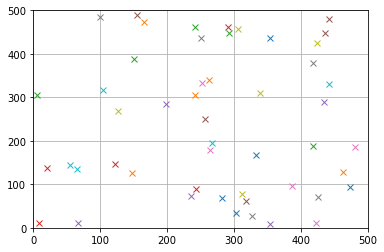

0


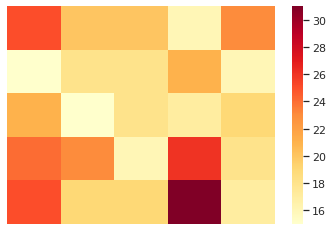

300


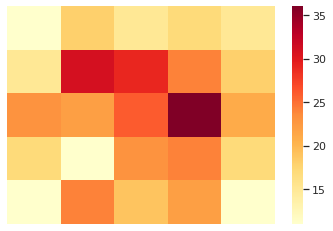

600


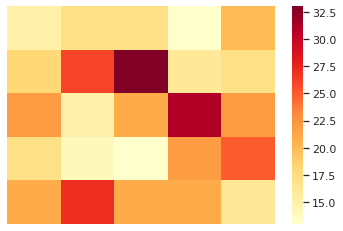

900


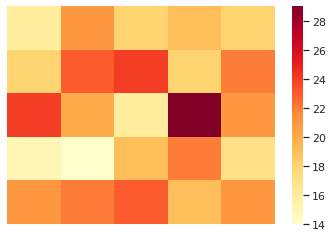

1200


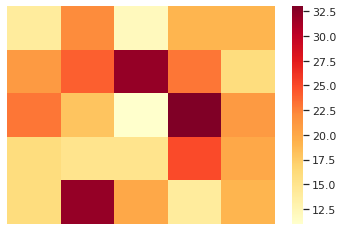

1500


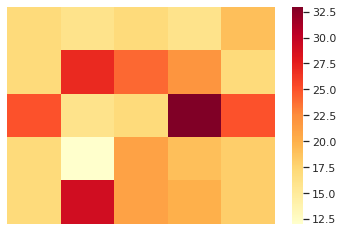

1800


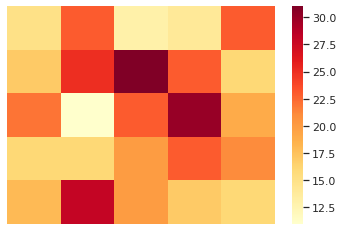

2100


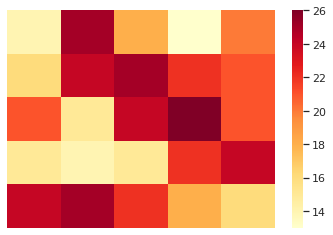

2400


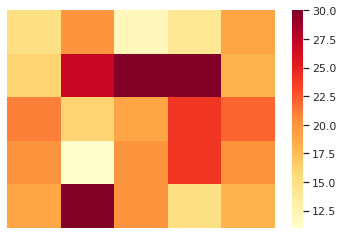

2700


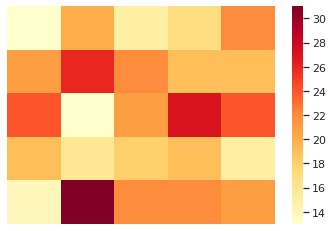

3000


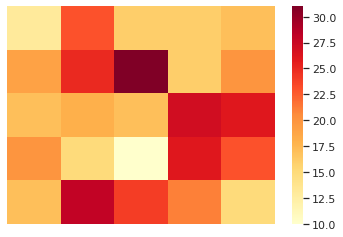

3300


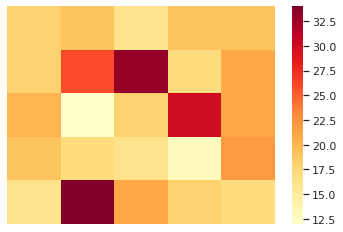

3600


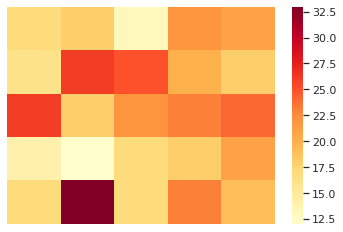

3900


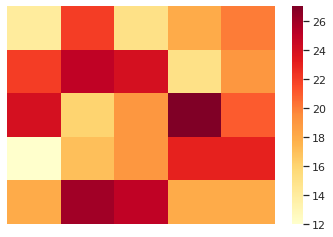

4200


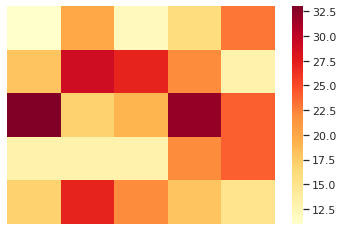

4500


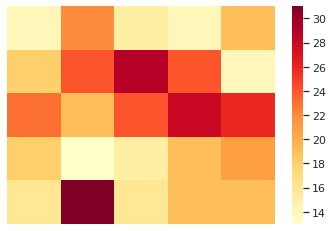

4800


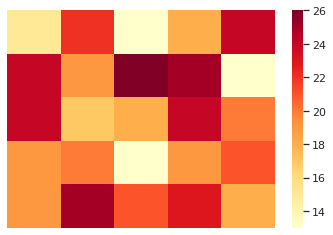

5100


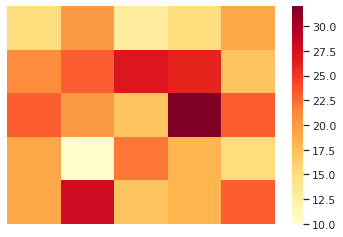

5400


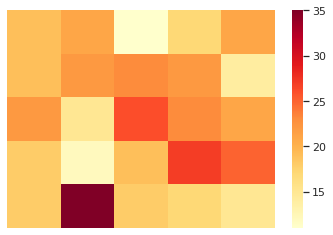

5700


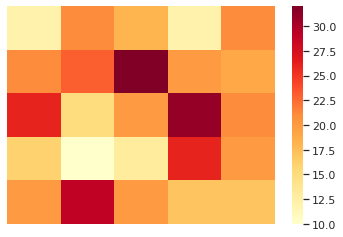

change transition
6000


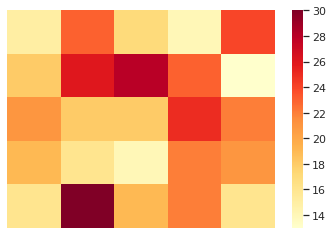

6300


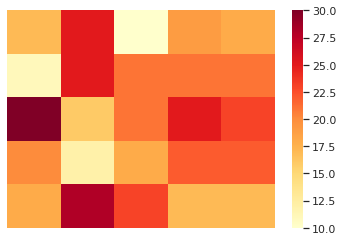

6600


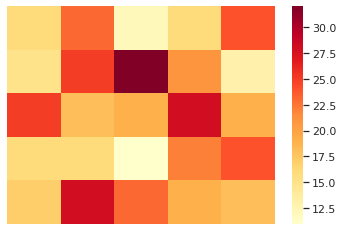

6900


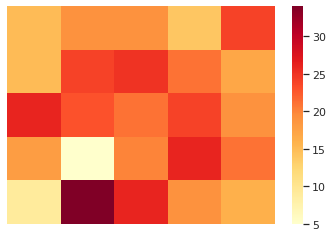

7200


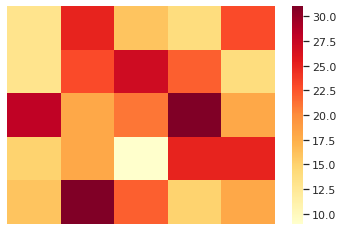

7500


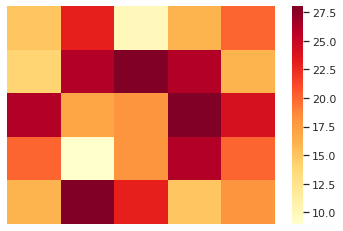

7800


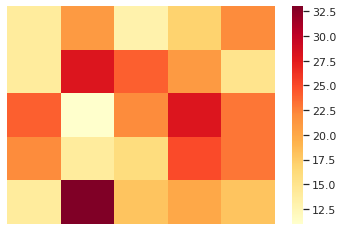

8100


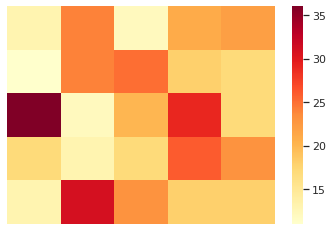

8400


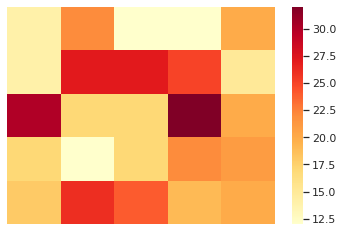

8700


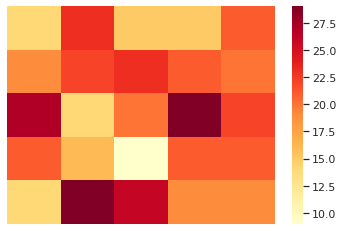

9000


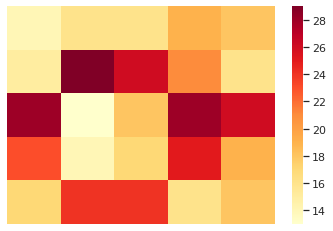

9300


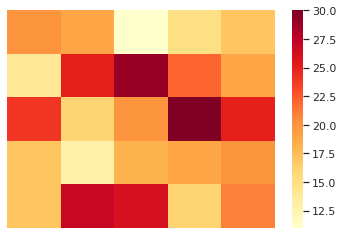

9600


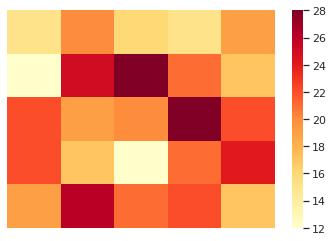

9900


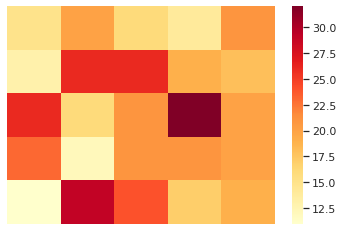

10200


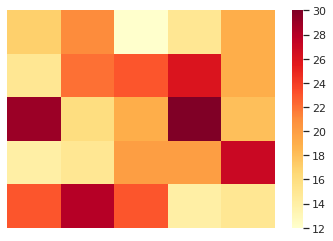

10500


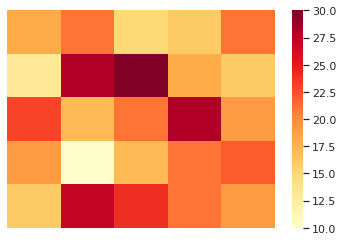

10800


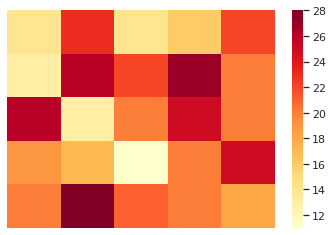

In [3]:
# create dataset

###parameters###

record_time_step = 10 # secondes
visualize_time = 300 # secondes
end_time = 181 # minutes
change_time = 100 # minutes

map_width = 500  # Width of the map
map_height = 500 # Height of the map
region_size = 100

nb_persons = 500
nb_homes = 500
#nb_home_central = 100
#nb_home_around = 10
#mean_home = 0
#stddev_home = 50

nb_pois = 50
#nb_pois_central = 5 
#nb_pois_around = 5
#nb_pois = nb_pois_central * nb_pois_around
#mean_pois = 0
#stddev_pois = 5

nb_stations = 100
#nb_stations_central = 5 
#nb_stations_around = 5
#nb_stations = nb_pois_central * nb_pois_around
#mean_stations = 0
#stddev_stations = 5

speed = 1.42

###parameters###

###files###

dir_name = "/home/kronos/Bureau/Thèse/mobility-prediction/simulation/webots/pf/controllers/pf2/data/"
dir_name += f"{nb_persons}_{end_time}/"

if not os.path.exists(dir_name):
    os.makedirs(dir_name)

###files###

################

end_time_seconds = end_time * 60
change_time_seconds = change_time * 60

mmap = Map(map_width, map_height)

#pois = generate_pois2(nb_pois_central, nb_pois_around, map_width, map_height, speed, mean=mean_pois, stddev=stddev_pois)
pois = generate_pois(nb_pois, map_width, map_height, speed)
[mmap.add_poi(p) for p in pois]

stations = generate_pois(nb_stations, map_width, map_height, speed)
#stations = generate_pois2(nb_stations_central, nb_stations_around, map_width, map_height, speed, mean=mean_stations, stddev=stddev_stations)
[mmap.add_station(s) for s in stations]

#homes = generate_pois2(nb_home_central, nb_home_around, map_width, map_height, speed, mean=mean_home, stddev=stddev_home)
homes = generate_pois(nb_homes, map_width, map_height, speed)
persons = generate_persons(nb_persons, mmap, homes, speed)
[mmap.add_person(p) for p in persons]

df_individuals = pd.DataFrame(columns=['user', 'x', 'y', 'time'])
df_density = pd.DataFrame(columns=['density', 'time'])
time = datetime(datetime.now().year, datetime.now().month, datetime.now().day, 0, 0, 0)

################

with open(dir_name+'param.txt', "w") as fichier:
    fichier.write(f'duration (minutes): {end_time}\n')
    fichier.write(f'\n')
    fichier.write(f'map dimensions: {map_width},{map_height}\n')
    fichier.write(f'region size: {region_size}\n')
    fichier.write(f'\n')
    fichier.write(f'nb persons: {nb_persons}\n')
    fichier.write(f'nb pois: {nb_pois}\n')
    fichier.write(f'persons\' speed: {speed}\n')
    

with open(dir_name+'start.csv', "w") as fichier:
    fichier.write('user,start_x,start_y,home_x,home_y\n')

    for id, p in mmap.people.items():
        fichier.write(f'{p.id},{p.x},{p.y},{p.home.x},{p.home.y}\n')
        
with open(dir_name+'poi.csv', "w") as fichier:
    fichier.write('poi,x,y\n')
    
    for p in mmap.poi:
        fichier.write(f'{p.name},{p.x},{p.y}\n')
        
with open(dir_name+'stations.csv', "w") as fichier:
    fichier.write('station,x,y\n')
    
    for s in mmap.stations:
        fichier.write(f'{s.name},{s.x},{s.y}\n')


################

mmap.visualize_pois()

for s in range(end_time_seconds):
    
    if s == change_time_seconds:
        
        # change transitions
        print('change transition')
        for _, person in mmap.people.items():
            transitions = []
            for _ in range(4):
                transitions.append(round(np.random.normal(0.4, 0.2),3))
            person.set_transitions(transitions)
    
    if s % record_time_step == 0:
        
        for id, p in mmap.people.items():
            
            row_individuals = pd.DataFrame({'user': [p.id], 'x': [p.x], 'y': [p.y], 'time': [time]})
            df_individuals  = pd.concat([df_individuals, row_individuals], ignore_index=True)
            
        density = mmap.calculate_density(region_size)
        row_density = pd.DataFrame({'density': [density], 'time': [time]})
        df_density  = pd.concat([df_density, row_density], ignore_index=True)
    
    if s % visualize_time == 0:
        print(s)
        density = mmap.calculate_density(region_size)
        mmap.visualize_density(region_size, density)   
        
        #print(mmap.people.get("0").state)
        #if mmap.people.get("0").destination:
        #    print(mmap.people.get("0").destination.name)
        #mmap.visualize()
    
    mmap.update()
    time += pd.Timedelta(seconds=1)
    
################

df_individuals.to_csv(dir_name+'data_individuals.csv', index=False)
df_density.to_csv(dir_name+'data_density.csv', index=False)